In [1]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator,
                          cross_val_multiscore, LinearModel, get_coef)

In [4]:
epochs1=mne.read_epochs('C:\\Users\\new user\\EEG data\\data\\Ex10_Suj1_Run1-epo.fif',preload=True)
epochs = epochs1[(epochs1.events[:,2] == 4) | (epochs1.events[:,2] == 5)]

Reading C:\Users\new user\EEG data\data\Ex10_Suj1_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
280 matching events found
Created an SSP operator (subspace dimension = 1)
280 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


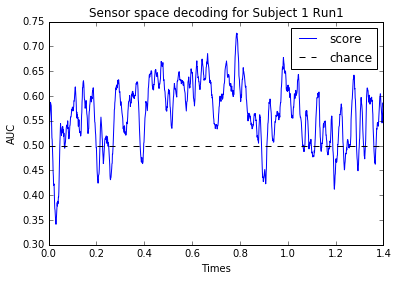

In [6]:
epochs.pick_types(eeg=True)
X = epochs.get_data()  # EEG signals: n_epochs, n_channels, n_times
y = epochs.events[:, 2]  #

clf = make_pipeline(StandardScaler(), LogisticRegression())

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')

scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding for Subject 1 Run1')
plt.show()

In [9]:
print(scores.shape)

(1401L,)


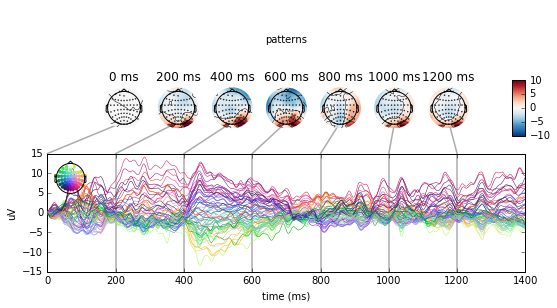

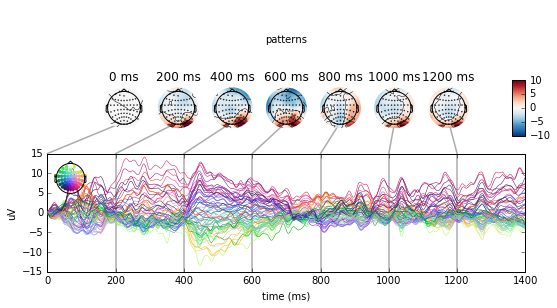

In [11]:
# You can retrieve the spatial filters and spatial patterns if you explicitly
# use a LinearModel
clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression()))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
evoked.plot_joint(times=np.arange(0., 1.400, .200), title='patterns')

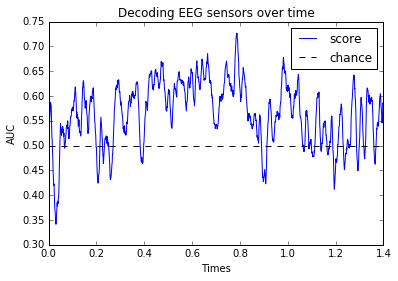

In [18]:
# define the Temporal Generalization object
time_gen = GeneralizingEstimator(clf, n_jobs=1, scoring='roc_auc')

scores = cross_val_multiscore(time_gen, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(epochs.times, np.diag(scores), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding EEG sensors over time')
plt.show()


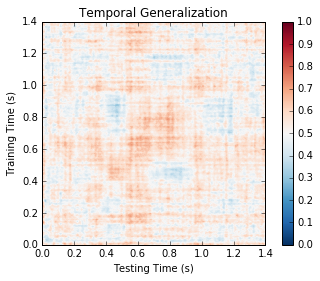

In [15]:
# Plot the full matrix
fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=1.)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal Generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)
plt.show()

In [16]:
epochs.info

<Info | 18 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, ...
    chs : list | 61 items (EEG: 61)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    file_id : dict | 4 items
    highpass : float | 1.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 40.0 Hz
    meas_date : ndarray | 2017-08-23 20:21:35 GMT
    meas_id : dict | 4 items
    nchan : int | 61
    proc_history : list | 0 items
    projs : list | Average EEG reference: on
    sfreq : float | 1000.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_layout :

In [16]:
y = epochs.events[:, 2] 
print(y)

[4 5 5 5 4 4 5 5 5 4 4 5 5 5 5 5 4 4 5 4 5 4 4 4 4 5 5 4 4 5 5 5 5 4 5 4 5
 5 5 5 4 5 4 4 4 5 5 5 5 5 4 4 4 4 5 4 5 4 4 4 4 4 4 5 5 4 5 4 5 5 5 4 5 5
 4 4 5 5 5 5 5 5 5 4 4 4 5 4 4 5 4 4 5 5 4 4 5 5 5 4 4 5 4 4 5 4 5 4 5 4 4
 5 4 4 5 5 4 4 5 4 5 5 5 5 5 4 4 5 4 4 4 4 4 4 4 4 5 4 5 4 4]


In [28]:
y = epochs.events[:, -1] 
print(y)

[4 5 5 5 4 4 5 5 5 4 4 5 5 5 5 5 4 4 5 4 5 4 4 4 4 5 5 4 4 5 5 5 5 4 5 4 5
 5 5 5 4 5 4 4 4 5 5 5 5 5 4 4 4 4 5 4 5 4 4 4 4 4 4 5 5 4 5 4 5 5 5 4 5 5
 4 4 5 5 5 5 5 5 5 4 4 4 5 4 4 5 4 4 5 5 4 4 5 5 5 4 4 5 4 4 5 4 5 4 5 4 4
 5 4 4 5 5 4 4 5 4 5 5 5 5 5 4 4 5 4 4 4 4 4 4 4 4 5 4 5 4 4]
